# Dynamic lot-size model

In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

## Formulation

$$
\begin{align}
    \text{min}~~ & \sum_{t \in T}{(h_{t} I_{t} + s_{t} y_{t})} \\
    \text{s.t.}~~ & I_{t} = I_{t - 1} + x_{t} - d_{t} & \forall ~ t \in T; t \geq 2\\
    & I_{1} = I_{0} + x_{1} - d_{1}\\
    & x_{t} \leq M y_{t} & \forall ~ t \in T \\
    & x_{t}; I_{t} \geq 0 & \forall ~ t \in T \\
    & y_{t} \in \left \{ 0, 1 \right \} & \forall ~ t \in T\\
\end{align}
$$

## Import data

In [2]:
# Read input data
dataset = pd.read_csv("./input_wagner.csv", index_col=0)
dataset.head()

,setup_cost,inventory_cost,demand
t,,,
1,85,1.0,69
2,102,1.0,29
3,102,1.0,36
4,101,1.0,61
5,98,1.0,61


In [3]:
# Obtain the maximum cost for comparison
max_cost = dataset.setup_cost.sum()
print(f"Maximum cost: {max_cost:.1f}")

Maximum cost: 1234.0


## pyomo model

In [37]:
# Initialize ConcreteModel
model = pyo.ConcreteModel()

In [38]:
# Set: Planning horizon
model.T = pyo.Set(initialize=dataset.index)

In [39]:
# Parameters
model.d = pyo.Param(model.T, initialize=dataset.demand.to_dict())
model.s = pyo.Param(model.T, initialize=dataset.setup_cost.to_dict())
model.h = pyo.Param(model.T, initialize=dataset.inventory_cost.to_dict())

# Big M (can we do better?)
model.M = pyo.Param(initialize=1_000)

In [40]:
# Decision variables
model.x = pyo.Var(model.T, within=pyo.NonNegativeReals)
model.y = pyo.Var(model.T, within=pyo.Binary)
model.I = pyo.Var(model.T, within=pyo.NonNegativeReals)

In [41]:
# Inventory balance *special in the first instant
def inventory_rule(model, t):
    if t == model.T.first():
        return model.I[t] == model.x[t] - model.d[t]
    else:
        t_prev = model.T.prev(t)
        return model.I[t] == model.I[t_prev] + model.x[t] - model.d[t]


model.inventory_rule = pyo.Constraint(model.T, rule=inventory_rule)

In [42]:
# Indicator constraint activates y in case x is greater than zero
def active_prod(model, t):
    return model.x[t] <= model.M * model.y[t]


model.active_prod = pyo.Constraint(model.T, rule=active_prod)

In [43]:
# Define the objective
def total_holding(model):
    return sum(model.h[t] * model.I[t] for t in model.T)


def total_setup(model):
    return sum(model.s[t] * model.y[t] for t in model.T)


def total_cost(model):
    return total_holding(model) + total_setup(model)


model.obj = pyo.Objective(rule=total_cost, sense=pyo.minimize)

## Solution

In [44]:
solver = pyo.SolverFactory("appsi_highs")

In [45]:
solver.solve(model, tee=True)

Running HiGHS 1.9.0 (git hash: fa40bdf): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+03]
  Cost   [1e+00, 1e+02]
  Bound  [1e+00, 1e+00]
  RHS    [3e+01, 8e+01]
Presolving model
23 rows, 34 cols, 56 nonzeros  0s
22 rows, 34 cols, 55 nonzeros  0s

Solving MIP model with:
   22 rows
   34 cols (11 binary, 0 integer, 0 implied int., 23 continuous)
   55 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   85              inf          

{'Problem': [{'Lower bound': 864.0, 'Upper bound': 864.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [46]:
opt_value = model.obj()
print(f"Best cost {opt_value}")
print(f"% savings {100 * (1 - opt_value / max_cost) :.2f}")

Best cost 864.0
% savings 29.98


In [35]:
dataset["production"] = [model.x[t].value for t in dataset.index]
dataset["inventory"] = [model.I[t].value for t in dataset.index]

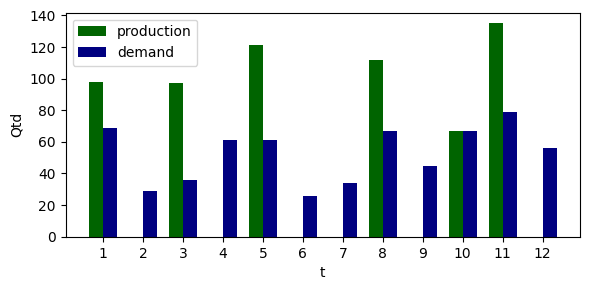

In [36]:
fig, ax = plt.subplots(figsize=[6, 3], dpi=100)
x = dataset.index
width = 0.35
ax.bar(x - width/2, dataset.production, width, color="darkgreen", label="production")
ax.bar(x + width/2, dataset.demand, width, color="navy", label="demand")
ax.set_xticks(x)
ax.set_ylabel("Qtd")
ax.set_xlabel("t")
ax.legend()
fig.tight_layout()
plt.show()